# ***Voorspellen van verhuuraantallen 2023*** 

Teamleden:
- Busse Heemskerk
- Declan van den Hoek
- Isa Dijkstra

In dit notebook worden er, aan de hand van een train dataset, verschillende Machine Learning modellen opgesteld om de meest accurate manier te vinden om diabetes te voorspellen.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks

data_test = pd.read_csv('test.csv', sep = ',')
data_train = pd.read_csv('train.csv', sep = ',')

In [3]:
data_train.head()


,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1


## **H1: Explorative Data Analysis**<a name='h1'></a>

De minimale vereisten voor Machine Learning met Scikit Learn zijn:

- De data mag geen missende waardes hebben
- De data moet bestaan uit numerieke waardes
- De data moet in een dataframe staan

Omdat de data is ingelezen via Pandas staat het al in een Pandas DataFrame, hierdoor kan gebruik gemaakt worden van de .info() methode van DataFrames om te kijken naar missende waarden en de datatypen.

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16637 entries, 0 to 16636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_hour   16637 non-null  object 
 1   holiday     16637 non-null  int64  
 2   weathersit  16637 non-null  int64  
 3   temp        16637 non-null  float64
 4   atemp       16637 non-null  float64
 5   hum         16637 non-null  float64
 6   windspeed   16637 non-null  float64
 7   cnt         16637 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 1.0+ MB


Uit de bovenstaande cel is af te leiden dat elke cel hetzelfde aantal waardes bevat. Dit zou aan kunnen geven dat er geen waardes missen. De datatypes zijn ook allemaal integers of floats (behalve de datum), hieruit is af te leiden dat deze kolommen bestaan uit numerieke waardes. 

In [5]:
data_train.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


Volgens de opdrachtbeschrijving zijn sommige kolommen al genormaliseerd, en zouden er geen maximale waardes boven de 1 moeten zijn. Als we naar de dataset kijken klopt dit, voor de kolommen "temp". "atemp" en "hum". Opvallend is dat de kolom "windspeed" ook genormaliseerd zou moeten zijn, maar de maximale waarde onder de 1.0 ligt. Dit kan aan geven dat de data niet goed is genormaliseerd. 

In [6]:
min_value = data_train['windspeed'].min()
max_value = data_train['windspeed'].max()

data_train['windspeed'] = (data_train['windspeed'] - min_value) / (max_value - min_value)

data_train.describe()

,holiday,weathersit,temp,atemp,hum,windspeed,cnt
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.223709,190.477009
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.143312,182.026755
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.122840,41.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.228047,143.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.298225,282.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,977.000000


In [7]:
def boxplot_outliers(dataframe, column_name, plot_title):
    plt.figure(figsize=(8, 6))
    plt.boxplot(dataframe[column_name], vert=False)  
    plt.title(plot_title)
    plt.show()

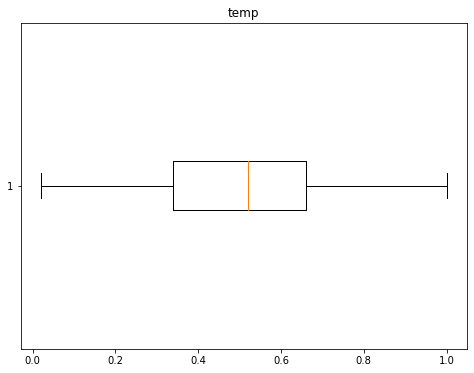

In [8]:
boxplot_outliers(data_train, 'temp', 'temp')

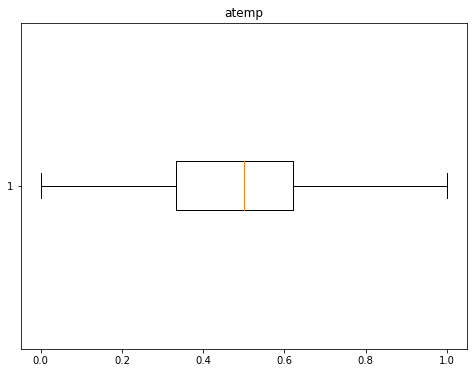

In [9]:
boxplot_outliers(data_train, 'atemp', 'atemp')

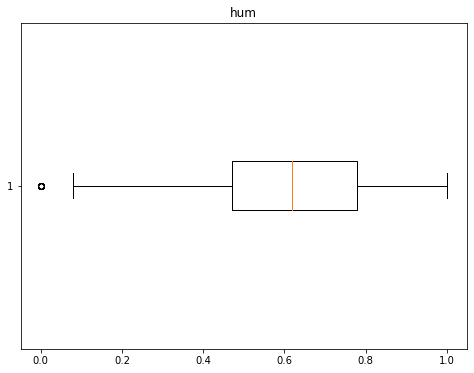

In [10]:
boxplot_outliers(data_train, 'hum', 'hum')

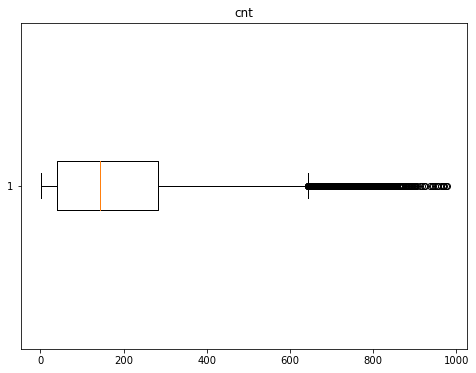

In [11]:
boxplot_outliers(data_train, 'cnt', 'cnt')

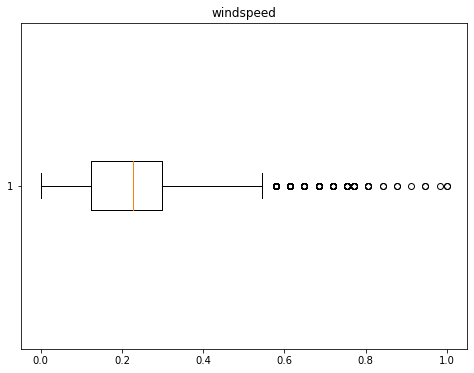

In [12]:
boxplot_outliers(data_train, 'windspeed', 'windspeed')

In de boxplot voor windspeed is te zien dat er een aantal outliers zijn. We gaan kijken naar deze rijen.

In [13]:
outliers_windspeed = data_train[data_train['windspeed'] > 0.58]


outliers_windspeed

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt
178,2011-01-08 17:00:00,0,1,0.16,0.1212,0.37,0.649112,69
194,2011-01-09 09:00:00,0,1,0.12,0.0758,0.46,0.614083,19
196,2011-01-09 11:00:00,0,1,0.16,0.1212,0.40,0.614083,49
265,2011-01-12 12:00:00,0,1,0.20,0.1515,0.47,0.684260,55
271,2011-01-12 18:00:00,0,1,0.20,0.1515,0.47,0.614083,137
...,...,...,...,...,...,...,...,...
15876,2012-10-28 17:00:00,0,3,0.46,0.4545,0.77,0.614083,225
16207,2012-11-13 01:00:00,0,3,0.44,0.4394,0.88,0.754438,5
16468,2012-11-23 22:00:00,0,1,0.44,0.4394,0.33,0.614083,79
16472,2012-11-24 02:00:00,0,1,0.32,0.2727,0.39,0.719290,32


In [14]:
def data_voorbereiding(base_df, dt_kol):
    """
    Een functie om een csv in te lezen en verschillende
    toepassingen uit te voeren op aanwezige timeseries
    data.

    Parameters:
    ----------
    base_df : pd.DataFrame
        De naam van het dataframe waar de extra
        timeseries kolommen worden gemaakt.
    
    dt_kol : str
        De naam van de kolom met de Timeseries data.

    Returns:
    ----------
    df : pd.DataFrame
        Een pandas.DataFrame waarin verschillende extra
        kolommen zijn toegevoegd waarin timeseries is
        toegepast.
    """
    
    # Omzetten van date_hour naar datetime
    df = base_df.copy()
    df[f'{dt_kol}'] = pd.to_datetime(df[f'{dt_kol}'])

    # Voeg nieuwe kolommen toe
    df['Jaar'] = df[f'{dt_kol}'].dt.year.astype(int)
    df['Maand'] = df[f'{dt_kol}'].dt.month.astype(int)
    df['Week'] = df[f'{dt_kol}'].dt.isocalendar().week.astype(int)
    df['Uur'] = df[f'{dt_kol}'].dt.hour.astype(int)
    df['is_weekend'] = (df[f'{dt_kol}'].dt.dayofweek >= 5).astype(int) # Later Toegevoegd
    df['day_of_week'] = df[f'{dt_kol}'].dt.weekday.astype(int) # Later Toegevoegd

    return df

In [15]:
df = data_voorbereiding(data_train, 'date_hour')
df.head()

,date_hour,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Jaar,Maand,Week,Uur,is_weekend,day_of_week
0,2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,52,0,1,5
1,2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,52,1,1,5
2,2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,52,2,1,5
3,2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,52,3,1,5
4,2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,52,4,1,5


In [16]:
df_test = data_voorbereiding(data_test, 'date_hour')
df_test.drop('date_hour', axis=1, inplace=True)

In [17]:
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

In [18]:
def submissie(model, suffix):
    """
    Deze functie maakt de voorspelling op de test dataset
    en vormt deze om tot een csv bestand om in te kunnen
    leveren op Kaggle.

    Parameters:
    ----------
    model : Machine Learning model
        De naam die is gegeven aan het ML-model dat
        wordt gebruikt om te voorspellen

    suffix : str
        De laatste 'tag' voor de naam van het csv
        bestand, zodat deze makkelijk te identificeren
        is na de submission.

    Returns:
    ----------
    None
        In plaats van een return maakt het een bestand
        aan in de map Kaggle Submissions. De namen zien
        er als volgt uit:

    """
    # Fitten, voorspellen en veranderen naar integer
    y_pred = model.fit(X_train, y_train).predict(df_test)
    y_pred = y_pred.astype(int)

    # Aanmaken df met alleen p_id en Outcome
    test_predictions_df = pd.DataFrame(
        {'date_hour': data_test['date_hour'],
        'cnt': y_pred})
    
    # Aanmaken van tijd
    tijd = datetime.datetime.now().strftime("%m%d%H%M%S")

    # Aanmaken csv bestand met timestamp
    test_predictions_df.to_csv(
        f'Kaggle Submissions/vs_{suffix}_{tijd}.csv',
        index=False)
    
    # print voor conformatie
    print(f'vs_{suffix}_{tijd}.csv has been saved!')

def model_score(model):
    """
    Een functie die de scores voor een model
    berekend en deze toont.

    Parameters:
    ----------
    model : elk ML model
    De naam van het gemaakte ML model

    Returns:
    ----------
    f1 : int
    De f1 score van het gegeven model
    """

    # Fitten en voorspellen met model
    y_pred = model.fit(X_train, y_train).predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Tonen van de resultaten
    return print(f'Root Mean Squared Error: {rmse}')

def grid_score(estimator, param_grid):
    """
    Een functie die de scores voor een grid search
    berekend en deze toont. Hierbij worden ook de
    optimale parameters getoont.

    Parameters:
    ----------
    estimator : ML model
    Het model waarop de grid search wordt toegepast

    param_grid : dict
    Een dictionary waarbij de keys parameter namen
    zijn van het model en de values verschillende
    waarden die de parameter aan kan nemen.

    Returns:
    ----------
    None
    Returned twee prints met de optimale parameters
    en beste f1 score
    """

    # Uitvoeren van de grid search
    gs = GridSearchCV(estimator=estimator,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='neg_root_mean_squared_error',
                    n_jobs=-1)
    
    # Fitten van de grid search
    gs.fit(X_train, y_train)

    # Tonen van de beste score en parameters
    print(f"Beste RMSE: {abs(gs.best_score_)}")
    print(f"Beste parameters:\n{gs.best_params_}")

def feature_scan(model):
    """
    Een functie die een grafie met de feature importances kan maken.
    Dit werkt in ieder geval voor de RF en XGB modellen.

    Parameters:
    ----------
    model : ML-model
    Het model waarvan je de feature importances wilt tonen.

    Returns:
    ----------
    None
    Laat een grafiek zien met daarin de invloed van alle features.
    """
    # Aanmaken en sorteren invloed kolommen
    invloed = pd.Series(model.feature_importances_, index=X.columns)
    invloed = invloed.sort_values(ascending=True)

    # Plotten grafiek met invloed
    invloed.plot(kind='barh', figsize=(10, 6))
    plt.ylabel('Features')
    plt.xlabel('Invloed')
    plt.show()
    

In [19]:
# Aanmaken SEED voor random_state
SEED = 42

# Aanmaken van X en y
df_train = df.drop(['date_hour'], axis=1)
X = df_train.drop('cnt', axis=1)
y = df_train['cnt']

# Splitten van de data in train en test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=456, random_state=SEED)

# Aanmaken van de folds
cv = TimeSeriesSplit(n_splits=5, test_size=456)

### H3.2 KNN Regressor

Wij hebben gekozen om een k-nearest neighbors model te gebruiken. Een K-nearest neighbours model (KNN) kan gebruikt worden voor classificatie of regressie problemen. In een KNN model word voor het voorspellen gekeken naar datapunten die in de buurt van de waarde die we willen voorspellen zitten, ofwel de "neighbours". Het model neemt dus de X waarden van de data die voorspeld moet worden, en vergelijkt dit met de X waarden van de trainingsdata die er vergelijkbaar uit ziet. Zo kan er een voorspelling worden gemaakt over de y waarde. Hier voor is er de mogelijkheid gebruik te maken van 3 verschillende metrics.(IBM, 2023) 

Er zijn enkele voordelen verbonden aan een KNN model. Zo is het model niet zo complex als andere modellen, wat de implementatie makkelijker maakt. Verder zijn er weinig hyperparameters, dit is zowel een voordeel als een nadeel.

Omdat het model redelijk simpel is, wordt er op andere vlakken ingeleverd. Zo kan het model met grotere datasets veel eisen van de computer. Ook is er een hogere kans op overfitting. (GeeksforGeeks, 2023)







In [20]:
# importeren benodigde module, kan verplaatst worden naar het begin
from sklearn.neighbors import KNeighborsRegressor

In [21]:
# opstellen K-Nearest Neighbors model
knn = KNeighborsRegressor(n_jobs=-1)

model_score(knn)

Root Mean Squared Error: 49.99937455749173


In [22]:
# Bekijken aantal neighbors
train_accuracies = {}
test_accuracies = {}
neighbors = range(1, 11)
for neighbor in neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbor)
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    test_accuracies[neighbor] = knn.score(X_test, y_test)
display(train_accuracies, test_accuracies)

{1: 1.0,
 2: 0.9278336386596009,
 3: 0.945331824412537,
 4: 0.9488836593744489,
 5: 0.9452902369770326,
 6: 0.9385192511473908,
 7: 0.9304495044385894,
 8: 0.9231153105257233,
 9: 0.9161075507151684,
 10: 0.9102565839587992}

{1: 0.6970684002236613,
 2: 0.8884421701589612,
 3: 0.9156669193123572,
 4: 0.9158737090317144,
 5: 0.9102413050905908,
 6: 0.8978686983445449,
 7: 0.8989992301949375,
 8: 0.8938953072306889,
 9: 0.8931743605754676,
 10: 0.8883250888227191}

In [23]:
knn = KNeighborsRegressor(n_neighbors=4)

model_score(knn)

Root Mean Squared Error: 48.405217737002964


In [24]:
# parameters voor de GridSearch
params_knn = {'weights':['uniform', 'distance'],
             'metric':['minkowski','euclidean','manhattan' ],
             'algorithm':['ball_tree', 'kd_tree', 'brute']}

grid_score(knn, params_knn)

Beste RMSE: 54.66264129260945
Beste parameters:
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'weights': 'distance'}


In [25]:
# uitkomsten GridSearch toepassen
knn_tuned = KNeighborsRegressor(algorithm='brute', n_jobs=-1, metric='minkowski', n_neighbors=4, weights='distance')

model_score(knn_tuned)

Root Mean Squared Error: 46.27652642179541


In [26]:
# submissie(knn_tuned, 'knn_tuned_2')

What is the k-nearest neighbors algorithm? | IBM. (n.d.). https://www.ibm.com/topics/knn

GeeksforGeeks. (2023, November 9). K Nearest neighbor KNN algorithm. https://www.geeksforgeeks.org/k-nearest-neighbours/

### Onderzoek naar trends 

Trend onderzoeken + trendcomponent toevoegen

Timeseries data is data verzameld over een periode van tijd. Deze data bestaat uit meerdere componenten, namelijk: de trendcomponent, seizoenscomponent, cyclische component en een willekeurig component. De trend component gaat over het gedrag van de data op de lange termijn, en negeert schommelingen op de korte termijn. Door het analyseren van de trendcomponent kunnen we data beter begrijpen, wat belangrijk is voor het voorspellen van toekomstige data. (Learn20stat, 2023)

Eerst onderzoeken we in hoeverre de trend component aanwezig is in onze data. Hier voor zijn er meerdere methoden die we kunnnen gebruiken. Een veel gebruikte methode is om moving averages te gebruiken. 

In [27]:
df_trend = df.set_index('date_hour')
df_trend

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Jaar,Maand,Week,Uur,is_weekend,day_of_week
date_hour,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.000000,16,2011,1,52,0,1,5
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.000000,40,2011,1,52,1,1,5
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.000000,32,2011,1,52,2,1,5
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.000000,13,2011,1,52,3,1,5
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.000000,1,2011,1,52,4,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.000000,377,2012,11,48,19,0,4
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.000000,245,2012,11,48,20,0,4
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.105325,183,2012,11,48,21,0,4


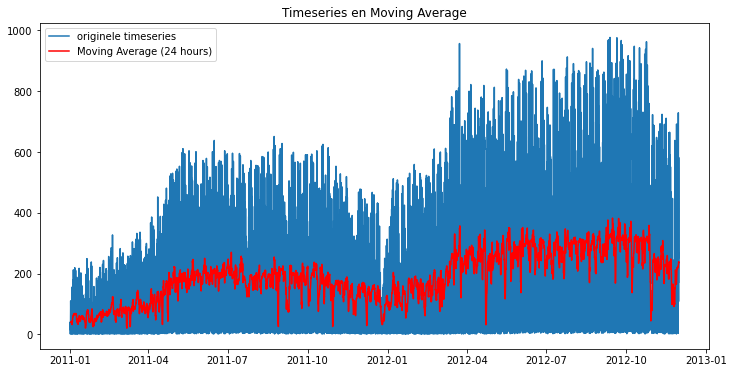

In [28]:
# Van date_hour de index maken
df_trend.index = pd.to_datetime(df_trend.index, format='%Y-%m-%d %H:%M:%S')  
df_trend = df_trend.asfreq('H')  

# Er voor zorgen dat er geen missende waardes zijn
df_trend['cnt'] = df_trend['cnt'].interpolate(method='linear', limit_direction='both')

# moving averages toepassen en toevoegen aan het dataframe
window_size = 24
df_trend['moving_avg'] = df_trend['cnt'].rolling(window=window_size).mean()


# De timeseries en trendcomponent tonen
plt.figure(figsize=(12, 6))
plt.plot(df_trend['cnt'], label='originele timeseries')
plt.plot(df_trend['moving_avg'], label=f'Moving Average ({window_size} hours)', color='red')
plt.legend()
plt.title('Timeseries en Moving Average')
plt.show()

In de grafiek is te zien dat er per jaar een boog gaat. De verhuuraantallen zijn in de zomer hoger. Goed te zien is dat de lijn in het tweede jaar in veel plekken hoger is dan in het vorige jaar. Dit kan een sterke opwaartse trend aangeven. Omdat de data over twee jaar gaat is het niet met zekerheid te zeggen of deze trend volhoud. 

bronnen voor dit hoofdstuk

Learn20stat. (2023, March 30). Components of time series. Learn Statistics. https://www.learn-stat.com/what-are-components-of-time-series/